In [31]:
import preprocessor
import demoji
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

In [32]:
# Load your dataset with columns 'tweet' and 'categories'
dataset = pd.read_csv('./dataset/cleaned_dataset.csv')
print(dataset.columns)
print(dataset.shape)
print(dataset.head(10))

Index(['label', 'tweet'], dtype='object')
(20620, 2)
   label                                              tweet
0      1   rt  boy dats coldtyga dwn bad for cuffin dat ...
1      1   rt  dawg rt  you ever fuck a bitch and she st...
2      1          rt ganderson based she look like a tranny
3      1   rt  the shit you hear about me might be true ...
4      1  madisonx the shit just blows meclaim you so fa...
5      1  brighterdays i can not just sit up and hate on...
6      1  8220 cause im tired of you big bitches coming ...
7      1   amp you might not get ya bitch back amp thats...
8      1               hobbies include fighting mariambitch
9      1   keeks is a bitch she curves everyone  lol i w...


In [33]:
# Load and preprocess your dataset
def preprocess_text(text):
    # Use tweet-preprocessor to clean tweets
    cleaned_text = preprocessor.clean(text)
    # Remove emojis
    cleaned_text = remove_emojis(cleaned_text)
    return cleaned_text

def remove_emojis(text):
    return demoji.replace(text, '')

# Preprocess text
dataset['cleaned_tweet'] = dataset['tweet'].apply(preprocess_text)

print(dataset.columns)
print(dataset.shape)
print(dataset.head(10))

Index(['label', 'tweet', 'cleaned_tweet'], dtype='object')
(20620, 3)
   label                                              tweet  \
0      1   rt  boy dats coldtyga dwn bad for cuffin dat ...   
1      1   rt  dawg rt  you ever fuck a bitch and she st...   
2      1          rt ganderson based she look like a tranny   
3      1   rt  the shit you hear about me might be true ...   
4      1  madisonx the shit just blows meclaim you so fa...   
5      1  brighterdays i can not just sit up and hate on...   
6      1  8220 cause im tired of you big bitches coming ...   
7      1   amp you might not get ya bitch back amp thats...   
8      1               hobbies include fighting mariambitch   
9      1   keeks is a bitch she curves everyone  lol i w...   

                                       cleaned_tweet  
0  rt boy dats coldtyga dwn bad for cuffin dat ho...  
1  rt dawg rt you ever fuck a bitch and she start...  
2          rt ganderson based she look like a tranny  
3  rt the shit y

In [34]:
# Split the dataset into training and testing sets
X_train, X_test_temp, y_train, y_test_temp = train_test_split(
    dataset['cleaned_tweet'],  # Features
    dataset['label'],  # Labels
    test_size=0.4, 
    random_state=42
)

# Split the testing set into validation (50%) and testing (50%)
X_val, X_test, y_val, y_test = train_test_split(
    X_test_temp,
    y_test_temp,
    test_size=0.5,
    random_state=42
)

# Reset the index to ensure it is consecutive
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Print the sizes of each set: Training 60% / Val 20% / Testing 20% 
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Testing set size:", len(X_test))

Training set size: 12372
Validation set size: 4124
Testing set size: 4124


In [9]:
# Load BERTweet model and tokenizer
model_name = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
def tokenize_data(text):
    return tokenizer(
        text,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

In [36]:
# Tokenize and prepare input data for training set
tokenized_train = X_train.apply(tokenize_data)
print("Training set size: ", len(tokenized_train))
print(tokenized_train.head(3))
tokenized_val = X_val.apply(tokenize_data)
print("Validation set size: ", len(tokenized_val))
print(tokenized_val.head(3))

# Create DataLoader for training set
input_ids_train = torch.cat([tokenized_train[i]['input_ids'] for i in range(len(tokenized_train))], dim=0)
attention_masks_train = torch.cat([tokenized_train[i]['attention_mask'] for i in range(len(tokenized_train))], dim=0)
labels_train = torch.tensor(y_train.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataloader_train = DataLoader(dataset_train, batch_size=8, shuffle=True)

# Create DataLoader for validation set
input_ids_val = torch.cat([tokenized_val[i]['input_ids'] for i in range(len(tokenized_val))], dim=0)
attention_masks_val = torch.cat([tokenized_val[i]['attention_mask'] for i in range(len(tokenized_val))], dim=0)
labels_val = torch.tensor(y_val.values)

dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataloader_val = DataLoader(dataset_val, batch_size=8, shuffle=False)

Training set size:  12372
0    [input_ids, token_type_ids, attention_mask]
1    [input_ids, token_type_ids, attention_mask]
2    [input_ids, token_type_ids, attention_mask]
Name: cleaned_tweet, dtype: object
Validation set size:  4124
0    [input_ids, token_type_ids, attention_mask]
1    [input_ids, token_type_ids, attention_mask]
2    [input_ids, token_type_ids, attention_mask]
Name: cleaned_tweet, dtype: object


In [37]:
# Set up optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
# loss_fn = torch.nn.BCEWithLogitsLoss()

# Set up training parameters
num_epochs = 2  # You can adjust this based on your requirements
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model and data to the device
model.to(device)
input_ids_train, attention_masks_train, labels_train = input_ids_train.to(device), attention_masks_train.to(device), labels_train.to(device)
input_ids_val, attention_masks_val, labels_val = input_ids_val.to(device), attention_masks_val.to(device), labels_val.to(device)
loss_per_epoch = {'train': [], 'val': []}
accuracy_per_epoch = {'train': [], 'val': []}

In [39]:
# Model Training
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch in tqdm(dataloader_train, desc=f'Training Epoch {epoch + 1}/{num_epochs}'):
        batch_input_ids, batch_attention_masks, batch_labels = batch
        batch_input_ids, batch_attention_masks, batch_labels = (
            batch_input_ids.to(device),
            batch_attention_masks.to(device),
            batch_labels.to(device),
        )

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            input_ids=batch_input_ids,
            attention_mask=batch_attention_masks,
            labels=batch_labels,
        )

        # Calculate loss
        loss = outputs.loss
        # loss = loss_fn(outputs.logits.squeeze(), batch_labels.float())

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        total_loss += loss.item()

        # Calculate training accuracy
        _, predicted_labels = torch.max(outputs.logits, 1)
        correct_predictions += (predicted_labels == batch_labels).sum().item()
        total_samples += batch_labels.size(0)

    # Calculate accuracy for the training epoch
    accuracy_train = correct_predictions / total_samples
    accuracy_per_epoch['train'].append(accuracy_train)

    # Calculate average loss for the training epoch
    average_loss_train = total_loss / len(dataloader_train)
    loss_per_epoch['train'].append(average_loss_train)
   
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_loss_train}, Train Accuracy: {accuracy_train}")

    # Validation
    model.eval()  # Set the model to evaluation mode
    total_loss_val = 0
    correct_predictions_val = 0
    total_samples_val = 0

    with torch.no_grad():  # Disable gradient computation during validation
        for batch_val in tqdm(dataloader_val, desc=f'Validation Epoch {epoch + 1}/{num_epochs}'):
            batch_input_ids, batch_attention_masks, batch_labels = batch_val
            batch_input_ids, batch_attention_masks, batch_labels = (
                batch_input_ids.to(device),
                batch_attention_masks.to(device),
                batch_labels.to(device),
            )
            outputs = model(
                    input_ids=batch_input_ids,
                    attention_mask=batch_attention_masks,
                    labels=batch_labels,
                )

            # loss_val = outputs.loss
            loss_val = outputs.loss
            total_loss_val += loss_val.item()

            _, predicted_labels_val = torch.max(outputs.logits, 1)
            correct_predictions_val += (predicted_labels_val == batch_labels).sum().item()
            total_samples_val += batch_labels.size(0)

    # Calculate accuracy for the validation epoch
    accuracy_val = correct_predictions_val / total_samples_val
    accuracy_per_epoch['val'].append(accuracy_val)

    # Calculate average loss for the validation epoch
    average_loss_val = total_loss_val / len(dataloader_val)
    loss_per_epoch['val'].append(average_loss_val)

    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {average_loss_val}, Validation Accuracy: {accuracy_val}")

# Save the trained model (This method is specific to the transformers library and is designed for saving transformer-based models.)
# It saves the model in a format that includes the architecture, parameters, and additional information specific to the transformers library.
# It provides a higher-level abstraction that is specific to transformer models and allows for easily loading the model using AutoModelForSequenceClassification.from_pretrained later.
model.save_pretrained("./model/BERTweet model")
tokenizer.save_pretrained("./model/BERTweet model")

# Plot the loss values
plt.figure(figsize=(12, 6))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), loss_per_epoch['train'], label='Training Loss', marker='o', linestyle='-', color='b')
plt.plot(range(1, num_epochs + 1), loss_per_epoch['val'], label='Validation Loss', marker='o', linestyle='-', color='r')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracy_per_epoch['train'], label='Training Accuracy', marker='o', linestyle='-', color='b')
plt.plot(range(1, num_epochs + 1), accuracy_per_epoch['val'], label='Validation Accuracy', marker='o', linestyle='-', color='r')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Training Epoch 1/2:   0%|          | 0/1547 [00:00<?, ?it/s]

Training Epoch 1/2:  15%|█▍        | 227/1547 [05:59<34:45,  1.58s/it]

In [13]:
# trained model
# lr = 5e-5
# batch size = 8
# epoch = 5
# total training time = 331 mins
# optimizer = AdamW

# Load the BERTweet tokenizer and model for sequence classification
model_path = "./model/BERTweet model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


BERTweet:
                     precision    recall  f1-score   support

        Hate Speech       0.00      0.00      0.00       282
Offensive Languages       0.93      1.00      0.96      3842

           accuracy                           0.93      4124
          macro avg       0.47      0.50      0.48      4124
       weighted avg       0.87      0.93      0.90      4124

13177    1
2432     1
4252     1
11072    1
6700     1
        ..
20091    1
9723     1
5548     0
13021    0
10845    1
Name: label, Length: 4124, dtype: int64
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

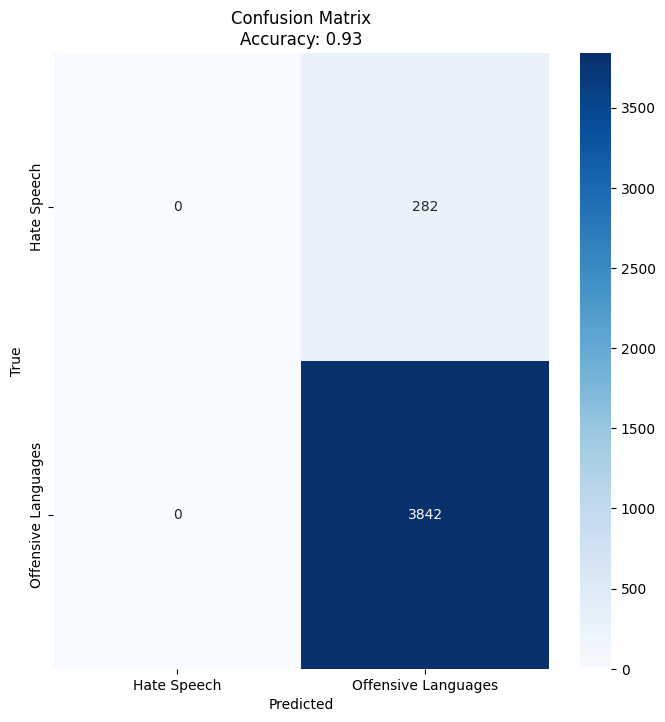

In [30]:
# Tokenize and prepare input data for testing set

# tokenized_test = tokenizer(X_test, return_tensors="pt")
tokenized_test = X_test.apply(tokenize_data)
# print(len(tokenized_test))
# print(tokenized_test)

label_dict = {'Hate Speech': 0, 'Offensive Languages': 1}

input_ids_test = torch.cat([tokenized_test[i]['input_ids'] for i in range(len(tokenized_test))], dim=0)
attention_masks_test = torch.cat([tokenized_test[i]['attention_mask'] for i in range(len(tokenized_test))], dim=0)
labels_test = torch.tensor(y_test.values)

# Create DataLoader for testing set
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
dataloader_test = DataLoader(dataset_test, batch_size=8, shuffle=False)

# Evaluation loop
model.eval()
all_preds = []

with torch.no_grad():
    for batch in dataloader_test:
        input_ids, attention_masks, labels = [tensor.to(device) for tensor in batch]

        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)

# Evaluate the model
print("BERTweet:")
print(classification_report(y_test, all_preds, target_names=label_dict.keys()))
print(y_test)
print(all_preds)
# Generate confusion matrix
conf_mat = confusion_matrix(y_test, all_preds)
accuracy_bertweet = accuracy_score(y_test, all_preds)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 8))
# sns.heatmap(conf_mat, annot=True, cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='g', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
plt.title(f'Confusion Matrix\nAccuracy: {accuracy_bertweet:.2f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
